**Drive + Dataset ZIP → Local runtime**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, zipfile, shutil


ZIP_PATH = "/content/drive/MyDrive/Music_Dataset_Final.zip"
LOCAL_DATA_DIR = "/content/Music_Dataset_Final"

# Clean previous extraction
if os.path.exists(LOCAL_DATA_DIR):
    shutil.rmtree(LOCAL_DATA_DIR)

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(LOCAL_DATA_DIR)

print("Extracted to:", LOCAL_DATA_DIR)


import glob
meta_candidates = glob.glob(LOCAL_DATA_DIR + "/**/metadata.csv", recursive=True)
print("metadata.csv candidates:", meta_candidates[:5])
assert len(meta_candidates) > 0, "metadata.csv not found after unzip"


METADATA = meta_candidates[0]
AUDIO_ROOT = os.path.dirname(METADATA)
print("AUDIO_ROOT:", AUDIO_ROOT)
print("METADATA:", METADATA)


print("Folders:", [d for d in os.listdir(AUDIO_ROOT) if os.path.isdir(os.path.join(AUDIO_ROOT,d))][:20])


Mounted at /content/drive
Extracted to: /content/Music_Dataset_Final
metadata.csv candidates: ['/content/Music_Dataset_Final/metadata.csv']
AUDIO_ROOT: /content/Music_Dataset_Final
METADATA: /content/Music_Dataset_Final/metadata.csv
Folders: ['rock_metal_clips', 'hiphop_clips', 'jazz_clips', 'pop_clips']


In [ ]:
!pip -q install librosa umap-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
import umap

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


**Reproducibility + Clustering Metrics (Silhouette/CH/DB/ARI/NMI/Purity)**

In [ ]:
import random, os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def cluster_purity(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    purity = 0
    n = len(y_true)
    for c in np.unique(y_pred):
        if c == -1:  # DBSCAN noise
            continue
        idx = np.where(y_pred == c)[0]
        if len(idx) == 0:
            continue
        purity += np.max(np.bincount(y_true[idx]))
    return purity / n if n > 0 else 0.0

def safe_silhouette(X, labels):
    labels = np.asarray(labels)
    X = np.asarray(X)
    # remove DBSCAN noise
    mask = labels != -1
    X2 = X[mask]
    y2 = labels[mask]
    if len(np.unique(y2)) < 2:
        return -1.0
    return float(silhouette_score(X2, y2))

def evaluate_all_metrics(X, y_pred, y_true=None):
    out = {}
    out["silhouette"] = safe_silhouette(X, y_pred)
    # CH/DB require >=2 clusters (excluding noise for DBSCAN)
    labels = np.asarray(y_pred)
    mask = labels != -1
    if len(np.unique(labels[mask])) >= 2:
        out["calinski_harabasz"] = float(calinski_harabasz_score(X[mask], labels[mask]))
        out["davies_bouldin"] = float(davies_bouldin_score(X[mask], labels[mask]))
    else:
        out["calinski_harabasz"] = -1.0
        out["davies_bouldin"] = -1.0

    if y_true is not None:
        y_true = np.asarray(y_true).astype(int)
        out["ari"] = float(adjusted_rand_score(y_true, y_pred))
        out["nmi"] = float(normalized_mutual_info_score(y_true, y_pred))
        out["purity"] = float(cluster_purity(y_true, y_pred))
    return out


**Dataset loading + label encoding + path resolver**

In [ ]:
df = pd.read_csv(METADATA)
print(df.head())
print("Total samples:", len(df))
print("Genre counts:\n", df["genre"].value_counts())

def normalize_genre(g):
    return str(g).strip().lower().replace(" ", "_")

# Map genre -> folder
folder_map = {
    "hiphop": "hiphop_clips",
    "rock_metal": "rock_metal_clips",
    "pop": "pop_clips",
    "jazz": "jazz_clips",
}

df["genre_norm"] = df["genre"].apply(normalize_genre)
df["folder"] = df["genre_norm"].map(folder_map)
assert df["folder"].isna().sum() == 0, "Some genres don't match folder_map. Check metadata genre names."

def audio_path_for_row(row):
    return os.path.join(AUDIO_ROOT, row["folder"], row["clip_name"])


missing = 0
for i, row in df.iterrows():
    p = audio_path_for_row(row)
    if not os.path.exists(p):
        missing += 1
        if missing <= 10:
            print("Missing:", p)
print("Total missing files:", missing)
assert missing == 0, "Fix missing paths before proceeding (full-marks strictness)."


genres = df["genre_norm"].astype("category")
y_true = genres.cat.codes.values
genre_names = list(genres.cat.categories)
num_clusters = len(genre_names)
print("num_clusters:", num_clusters, "genre_names:", genre_names)


                                clip_name  \
0  Eminem - Lose Yourself [HD]_part_1.mp3   
1  Eminem - Lose Yourself [HD]_part_2.mp3   
2  Eminem - Lose Yourself [HD]_part_3.mp3   
3  Eminem - Lose Yourself [HD]_part_4.mp3   
4  Eminem - Lose Yourself [HD]_part_5.mp3   

                                              lyrics   genre  
0                                                NaN  hiphop  
1                       Look, if you head, one shot.  hiphop  
2  I won't opportunity I see everything you ever ...  hiphop  
3  But on the surface he looks calm and ready to ...  hiphop  
4  He's so mad but he won't give up that he's he ...  hiphop  
Total samples: 3368
Genre counts:
 genre
rock metal    1068
hiphop        1000
jazz           688
pop            612
Name: count, dtype: int64
Total missing files: 0
num_clusters: 4 genre_names: ['hiphop', 'jazz', 'pop', 'rock_metal']


**Build Hard Multimodal Features (MFCC + Lyrics + Genre One-Hot)**

In [ ]:
# --------------------------------------------------
# Build Hard Multimodal Features
# (MFCC + Lyrics + Genre One-Hot)
# --------------------------------------------------
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ---------------------------
# Paths (IMPORTANT)
# ---------------------------
DATASET_ROOT = "/content/Music_Dataset_Final"
META_PATH = os.path.join(DATASET_ROOT, "metadata.csv")

# ---------------------------
# Load metadata
# ---------------------------
df = pd.read_csv(META_PATH)

def clean_lyrics(text):
    if pd.isna(text):
        return ""
    text = str(text).lower().strip()
    if text == "music":
        return ""
    return text

df["lyrics_clean"] = df["lyrics"].apply(clean_lyrics)

# Normalize genre
df["genre_norm"] = (
    df["genre"]
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
)

print("Total samples:", len(df))

# ---------------------------
# 1) MFCC extraction (HARD)
# ---------------------------
def extract_mfcc(audio_path, sr=22050, n_mfcc=40):
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

mfcc_list = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    genre_folder = f"{row['genre_norm']}_clips"
    audio_path = os.path.join(DATASET_ROOT, genre_folder, row["clip_name"])

    try:
        mfcc = extract_mfcc(audio_path)
    except Exception as e:
        raise RuntimeError(f"MFCC failed for {audio_path}") from e

    mfcc_list.append(mfcc)

X_mfcc = np.array(mfcc_list, dtype=np.float32)
print("MFCC shape:", X_mfcc.shape)

# ---------------------------
# 2) Lyrics TF-IDF + SVD
# ---------------------------
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(df["lyrics_clean"]).astype(np.float32)

svd_dim = 256
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
X_ly = svd.fit_transform(X_tfidf).astype(np.float32)

print("Lyrics reduced shape:", X_ly.shape)

# ---------------------------
# 3) Genre one-hot (scaled)
# ---------------------------
genre_onehot = pd.get_dummies(df["genre_norm"]).values.astype(np.float32)

# IMPORTANT scaling to avoid posterior collapse
genre_onehot = genre_onehot * 3.0

print("Genre onehot shape:", genre_onehot.shape)

# Labels for evaluation
le = LabelEncoder()
y_true = le.fit_transform(df["genre_norm"].values)
genre_names = le.classes_.tolist()

# ---------------------------
# 4) Scale MFCC + lyrics
# ---------------------------
sc_mfcc = StandardScaler()
sc_ly = StandardScaler()

X_mfcc_s = sc_mfcc.fit_transform(X_mfcc)
X_ly_s = sc_ly.fit_transform(X_ly)

# ---------------------------
# 5) Final HARD input
# ---------------------------
X_hard = np.concatenate(
    [X_mfcc_s, X_ly_s, genre_onehot],
    axis=1
).astype(np.float32)

print("X_hard:", X_hard.shape)


Total samples: 3368


100%|██████████| 3368/3368 [06:19<00:00,  8.86it/s]


MFCC shape: (3368, 40)
Lyrics reduced shape: (3368, 256)
Genre onehot shape: (3368, 4)
X_hard: (3368, 300)


**Beta-VAE (disentanglement via β)**

In [ ]:
X_tensor = torch.tensor(X_hard, dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)

input_dim = X_hard.shape[1]
latent_dim = 32

# 2) Beta-VAE model
class BetaVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return self.fc5(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

model = BetaVAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3) Loss with parts (so we can log recon and KL)
def beta_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon = F.mse_loss(recon_x, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # should be >= 0
    return recon + beta * kl, recon, kl

**Train Beta-VAE (GPU) + Extract Latent**

In [ ]:
epochs = 300
beta_max = 4.0
warmup = 40  # ramp beta from 0->beta_max in first 40 epochs

N = X_tensor.shape[0]
model.train()

for ep in range(1, epochs + 1):
    beta = beta_max * min(1.0, ep / warmup)

    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0

    for (xb,) in loader:
        xb = xb.to(device)
        opt.zero_grad()

        recon_x, mu, logvar = model(xb)
        loss, recon_part, kl_part = beta_vae_loss(recon_x, xb, mu, logvar, beta=beta)

        loss.backward()
        opt.step()

        total_loss += loss.item()
        total_recon += recon_part.item()
        total_kl += kl_part.item()

    # per-sample logging (stable for reports)
    avg_loss = total_loss / N
    avg_recon = total_recon / N
    avg_kl = total_kl / N

    if ep % 10 == 0 or ep == 1:
        print(f"Epoch {ep}/{epochs} beta={beta:.3f} loss={avg_loss:.4f} recon={avg_recon:.4f} kl={avg_kl:.4f}")

# 5) Extract latent vectors
model.eval()
with torch.no_grad():
    mu_all, _ = model.encode(X_tensor.to(device))
    Z_hard = mu_all.cpu().numpy()

print("Z_hard shape:", Z_hard.shape)

# 6) Sanity check: recon vs KL (should NOT be ~0 KL anymore)
def recon_kl_parts(recon_x, x, mu, logvar):
    recon = F.mse_loss(recon_x, x, reduction="sum").item()
    kl = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())).item()
    return recon, kl

with torch.no_grad():
    xb = X_tensor[:512].to(device)
    recon_x, mu, logvar = model(xb)
    recon_part, kl_part = recon_kl_parts(recon_x, xb, mu, logvar)

print("Recon per sample:", recon_part / xb.size(0))
print("KL per sample:", kl_part / xb.size(0))

Epoch 1/300 beta=0.100 loss=304.0847 recon=303.9540 kl=1.3066
Epoch 10/300 beta=1.000 loss=272.5511 recon=259.0485 kl=13.5026
Epoch 20/300 beta=2.000 loss=261.4274 recon=239.8189 kl=10.8043
Epoch 30/300 beta=3.000 loss=258.9744 recon=232.5489 kl=8.8085
Epoch 40/300 beta=4.000 loss=260.0802 recon=230.4359 kl=7.4111
Epoch 50/300 beta=4.000 loss=254.7887 recon=225.7632 kl=7.2564
Epoch 60/300 beta=4.000 loss=250.7153 recon=221.0899 kl=7.4063
Epoch 70/300 beta=4.000 loss=247.0168 recon=217.6059 kl=7.3527
Epoch 80/300 beta=4.000 loss=243.6954 recon=214.3379 kl=7.3394
Epoch 90/300 beta=4.000 loss=241.4796 recon=211.6675 kl=7.4530
Epoch 100/300 beta=4.000 loss=239.3972 recon=209.4660 kl=7.4828
Epoch 110/300 beta=4.000 loss=237.3444 recon=207.3092 kl=7.5088
Epoch 120/300 beta=4.000 loss=235.6005 recon=205.2578 kl=7.5857
Epoch 130/300 beta=4.000 loss=234.3018 recon=203.6806 kl=7.6553
Epoch 140/300 beta=4.000 loss=233.3076 recon=202.4187 kl=7.7222
Epoch 150/300 beta=4.000 loss=231.2368 recon=200.

**Hard Task Clustering + Required Metrics (Silhouette/NMI/ARI/Purity)**

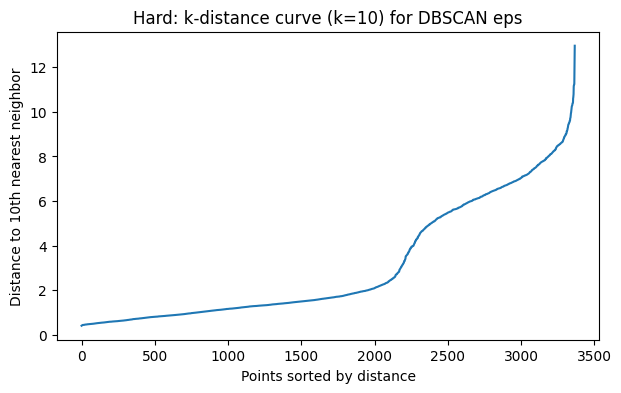

Best DBSCAN: {'eps': 3.0, 'min_samples': 10, 'n_clusters': 2, 'n_noise': 1156, 'silhouette': 0.5459952354431152, 'labels': array([ 0, -1, -1, ..., -1,  0,  0])}


,method,silhouette,calinski_harabasz,davies_bouldin,ari,nmi,purity
0,BetaVAE+KMeans (Z_norm),0.065218,244.259705,2.713913,0.292840,0.264055,0.556710
1,BetaVAE+Agglo (Z_norm),0.331233,205.945038,3.025633,0.039211,0.043785,0.366686
2,"BetaVAE+DBSCAN (Z_norm, eps=3.0, ms=10)",0.545995,104.672462,0.526927,0.050001,0.046925,0.246437


In [ ]:
from sklearn.neighbors import NearestNeighbors
#normalize latent for clustering stability
Z_use = StandardScaler().fit_transform(Z_hard)

hard_results = []

# --- KMeans (primary) ---
pred_km = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(Z_use)
hard_results.append({"method":"BetaVAE+KMeans (Z_norm)", **evaluate_all_metrics(Z_use, pred_km, y_true)})

# --- Agglomerative ---
pred_ag = AgglomerativeClustering(n_clusters=num_clusters).fit_predict(Z_use)
hard_results.append({"method":"BetaVAE+Agglo (Z_norm)", **evaluate_all_metrics(Z_use, pred_ag, y_true)})

# --- DBSCAN: choose eps using k-distance + grid search ---
k = 10  # usually align with min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(Z_use)
distances, _ = nbrs.kneighbors(Z_use)
k_dist = np.sort(distances[:, -1])

# Quick elbow plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(k_dist)
plt.title(f"Hard: k-distance curve (k={k}) for DBSCAN eps")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.show()

def dbscan_summary(labels):
    labels = np.asarray(labels)
    n_noise = int(np.sum(labels == -1))
    n_clusters = int(len(set(labels)) - (1 if -1 in labels else 0))
    return n_clusters, n_noise

best_db = None
eps_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]   # widen if needed
min_samples_list = [5, 10, 20]

for eps in eps_list:
    for ms in min_samples_list:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(Z_use)
        n_clusters, n_noise = dbscan_summary(labels)

        # accept only if >=2 clusters and enough non-noise points
        if n_clusters >= 2 and (len(Z_use) - n_noise) > 50:
            sil = safe_silhouette(Z_use, labels)
            if best_db is None or sil > best_db["silhouette"]:
                best_db = {
                    "eps": eps, "min_samples": ms,
                    "n_clusters": n_clusters, "n_noise": n_noise,
                    "silhouette": sil, "labels": labels
                }

print("Best DBSCAN:", best_db)

if best_db is not None:
    pred_db_best = best_db["labels"]
    hard_results.append({
        "method": f"BetaVAE+DBSCAN (Z_norm, eps={best_db['eps']}, ms={best_db['min_samples']})",
        **evaluate_all_metrics(Z_use, pred_db_best, y_true)
    })
else:
    pred_db_best = None
    print("DBSCAN did not form >=2 clusters in this eps/ms grid (this is acceptable; report it).")

pd.DataFrame(hard_results)


**PCA + KMeans baseline**

In [ ]:


# PCA baseline on X_hard (already scaled inputs are recommended)
Z_pca = PCA(n_components=32, random_state=42).fit_transform(X_hard)

# normalize PCA embedding for fair clustering
Z_pca_use = StandardScaler().fit_transform(Z_pca)

pred_pca = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(Z_pca_use)
base_pca = {"method":"PCA(32)+KMeans", **evaluate_all_metrics(Z_pca_use, pred_pca, y_true)}
base_pca


{'method': 'PCA(32)+KMeans',
 'silhouette': 0.03155893832445145,
 'calinski_harabasz': 97.16398620605469,
 'davies_bouldin': 4.132266446836226,
 'ari': 0.8046770596543131,
 'nmi': 0.8563688979217755,
 'purity': 0.9082541567695962}

**Autoencoder + KMeans baseline (deterministic AE)**

In [ ]:


class AE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def forward(self, x):
        z = self.enc(x)
        recon = self.dec(z)
        return recon, z

X_tensor = torch.tensor(X_hard, dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)

ae = AE(input_dim=X_hard.shape[1], latent_dim=32).to(device)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)

epochs = 80
N = X_tensor.shape[0]

ae.train()
for ep in range(1, epochs+1):
    total = 0.0
    for (xb,) in loader:
        xb = xb.to(device)
        opt.zero_grad()
        recon, z = ae(xb)
        loss = F.mse_loss(recon, xb, reduction="sum")
        loss.backward()
        opt.step()
        total += loss.item()

    if ep % 10 == 0 or ep == 1:
        print(f"AE Epoch {ep}/{epochs} loss_per_sample={total/N:.4f}")

ae.eval()
with torch.no_grad():
    _, Z_ae = ae(X_tensor.to(device))
    Z_ae = Z_ae.cpu().numpy()

Z_ae_use = StandardScaler().fit_transform(Z_ae)
pred_ae = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(Z_ae_use)
base_ae = {"method":"AE(32)+KMeans", **evaluate_all_metrics(Z_ae_use, pred_ae, y_true)}
base_ae


AE Epoch 1/80 loss_per_sample=292.2240
AE Epoch 10/80 loss_per_sample=200.4630
AE Epoch 20/80 loss_per_sample=166.7027
AE Epoch 30/80 loss_per_sample=152.6025
AE Epoch 40/80 loss_per_sample=144.5616
AE Epoch 50/80 loss_per_sample=139.6782
AE Epoch 60/80 loss_per_sample=135.9452
AE Epoch 70/80 loss_per_sample=133.0606
AE Epoch 80/80 loss_per_sample=130.7838


{'method': 'AE(32)+KMeans',
 'silhouette': 0.2448451817035675,
 'calinski_harabasz': 87.07930755615234,
 'davies_bouldin': 3.5949213318733815,
 'ari': 0.07704763230980813,
 'nmi': 0.08511686487500397,
 'purity': 0.39815914489311166}

**Direct spectral feature clustering baseline (MFCC directly)**

In [ ]:
# X_mfcc_s is already StandardScaler output from your hard feature build
X_mfcc_use = X_mfcc_s  # already scaled

pred_mfcc = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(X_mfcc_use)
base_spec = {"method":"Direct_MFCC(40)+KMeans", **evaluate_all_metrics(X_mfcc_use, pred_mfcc, y_true)}
base_spec


{'method': 'Direct_MFCC(40)+KMeans',
 'silhouette': 0.1103011816740036,
 'calinski_harabasz': 263.7181701660156,
 'davies_bouldin': 2.109407647737538,
 'ari': 0.11768977864837217,
 'nmi': 0.18751128099499179,
 'purity': 0.48485748218527314}

**One comparison table**

In [ ]:
all_rows = []
all_rows.extend(hard_results)
all_rows.extend([base_pca, base_ae, base_spec])

df_compare = pd.DataFrame(all_rows)

# Sort by silhouette first; if tie, by ARI then NMI
sort_cols = [c for c in ["silhouette", "ari", "nmi", "purity"] if c in df_compare.columns]
df_compare = df_compare.sort_values(sort_cols, ascending=False)

df_compare


,method,silhouette,calinski_harabasz,davies_bouldin,ari,nmi,purity
2,"BetaVAE+DBSCAN (Z_norm, eps=3.0, ms=10)",0.545995,104.672462,0.526927,0.050001,0.046925,0.246437
1,BetaVAE+Agglo (Z_norm),0.331233,205.945038,3.025633,0.039211,0.043785,0.366686
4,AE(32)+KMeans,0.244845,87.079308,3.594921,0.077048,0.085117,0.398159
5,Direct_MFCC(40)+KMeans,0.110301,263.718170,2.109408,0.117690,0.187511,0.484857
0,BetaVAE+KMeans (Z_norm),0.065218,244.259705,2.713913,0.292840,0.264055,0.556710
3,PCA(32)+KMeans,0.031559,97.163986,4.132266,0.804677,0.856369,0.908254


**Detailed Visualizations (latent plots, cluster distribution by genre, recon examples)**

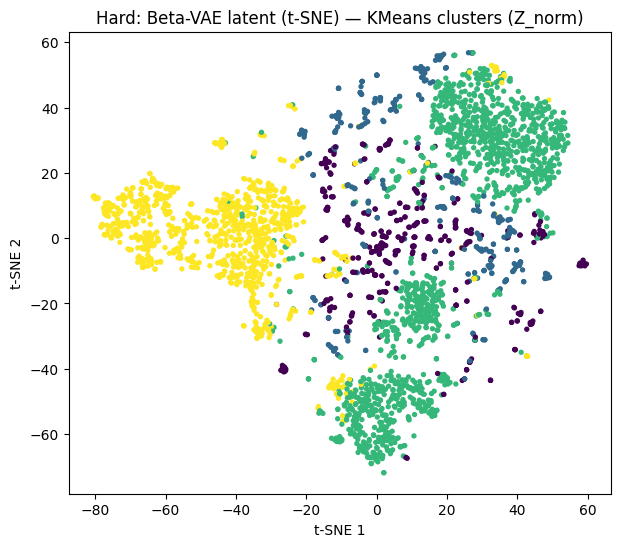

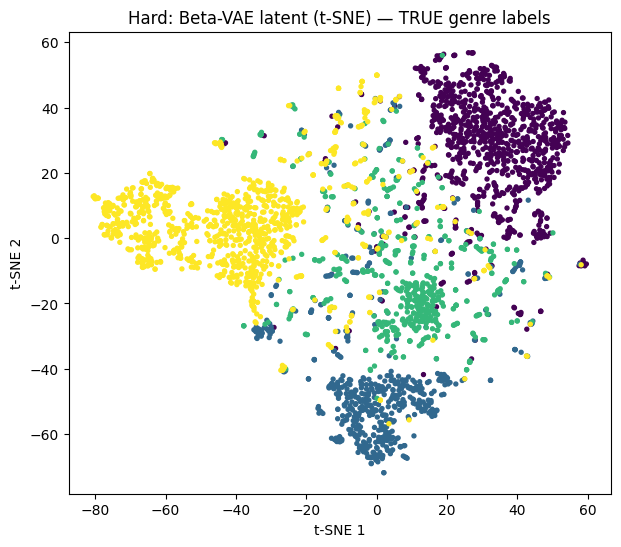

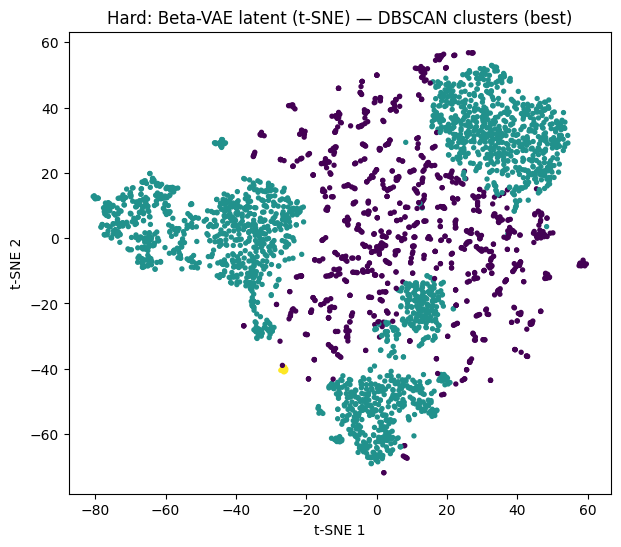

genre_norm,hiphop,jazz,pop,rock_metal
row_0,,,,
0,114,94,172,84
1,125,70,89,120
2,737,443,292,23
3,24,81,59,841


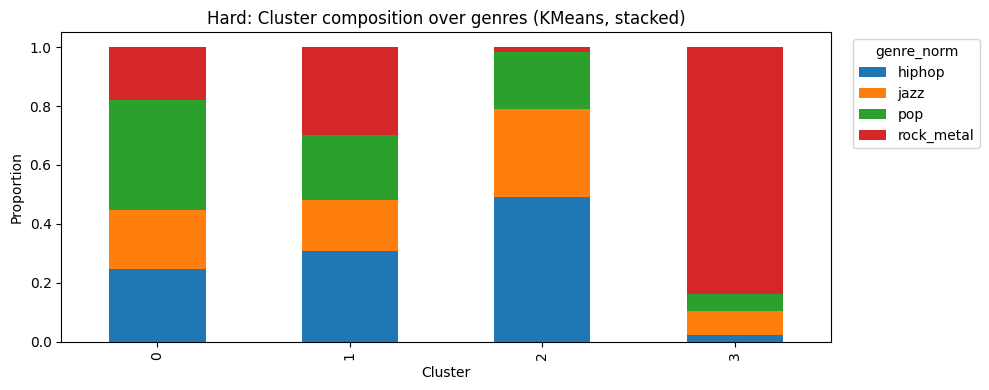

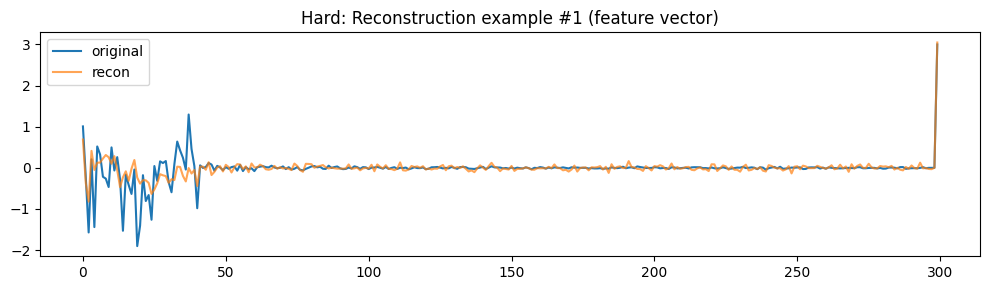

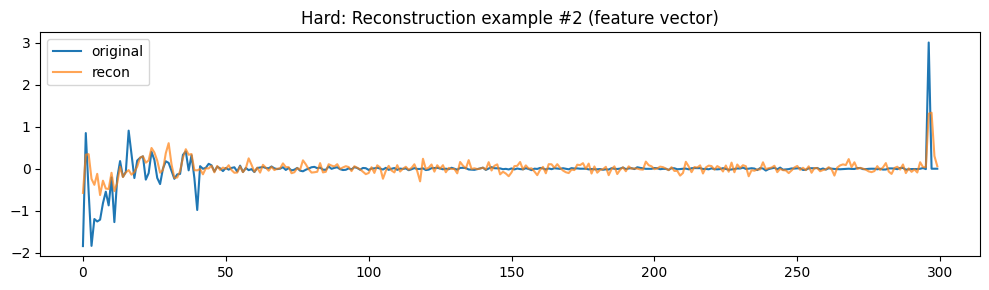

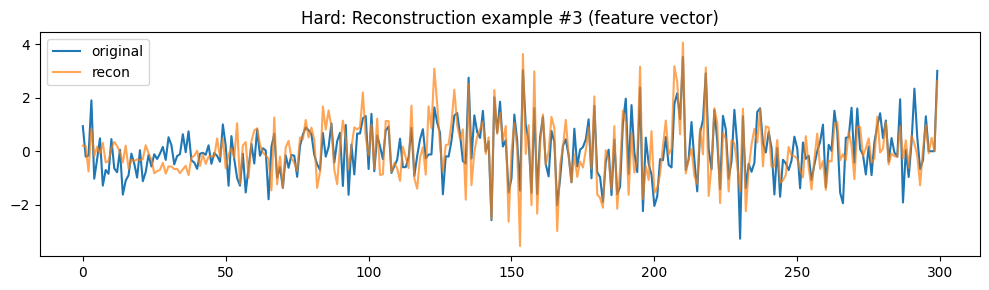

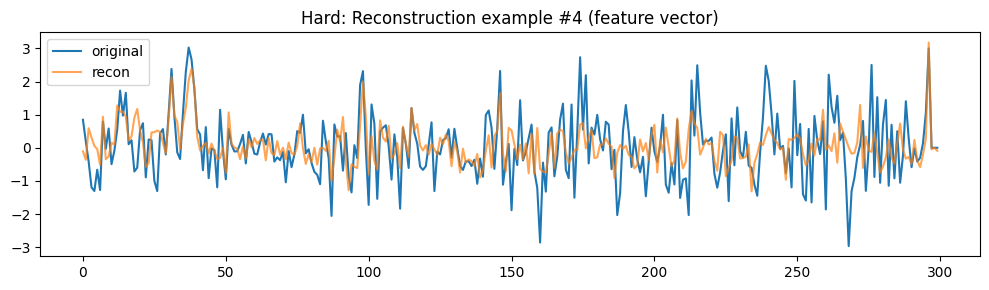

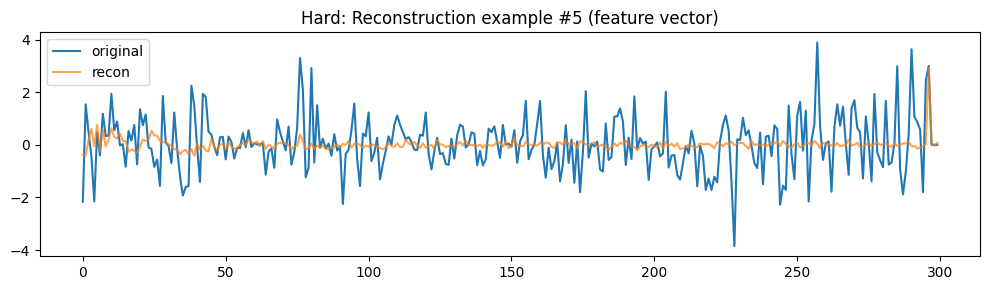

In [ ]:
# t-SNE on normalized latent (matches clustering)
Z2 = TSNE(n_components=2, random_state=42).fit_transform(Z_use)

# 1) Latent colored by KMeans clusters
plt.figure(figsize=(7,6))
plt.scatter(Z2[:,0], Z2[:,1], c=pred_km, s=8)
plt.title("Hard: Beta-VAE latent (t-SNE) — KMeans clusters (Z_norm)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.show()

# 2) Latent colored by TRUE genre
plt.figure(figsize=(7,6))
plt.scatter(Z2[:,0], Z2[:,1], c=y_true, s=8)
plt.title("Hard: Beta-VAE latent (t-SNE) — TRUE genre labels")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.show()

# 3) Latent colored by DBSCAN best (if exists)
if pred_db_best is not None:
    plt.figure(figsize=(7,6))
    plt.scatter(Z2[:,0], Z2[:,1], c=pred_db_best, s=8)
    plt.title("Hard: Beta-VAE latent (t-SNE) — DBSCAN clusters (best)")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.show()

# 4) Cluster distribution over genres (KMeans)
dist = pd.crosstab(pred_km, df["genre_norm"])
display(dist)

dist_norm = dist.div(dist.sum(axis=1), axis=0)
ax = dist_norm.plot(kind="bar", stacked=True, figsize=(10,4))
plt.title("Hard: Cluster composition over genres (KMeans, stacked)")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.legend(title="genre_norm", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 5) Reconstruction examples (feature-space)
model.eval()
with torch.no_grad():
    idx = np.random.choice(len(X_hard), size=5, replace=False)
    xb = torch.tensor(X_hard[idx], dtype=torch.float32).to(device)
    recon, mu, logvar = model(xb)

xb = xb.cpu().numpy()
recon = recon.cpu().numpy()

for i in range(5):
    plt.figure(figsize=(10,3))
    plt.plot(xb[i], label="original")
    plt.plot(recon[i], label="recon", alpha=0.7)
    plt.title(f"Hard: Reconstruction example #{i+1} (feature vector)")
    plt.legend()
    plt.tight_layout()
    plt.show()


**Save Hard Task Results + ZIP**

In [ ]:
from google.colab import files

# -------------------------------
# Output directory
# -------------------------------
OUT_DIR = "/content/results_hard"
os.makedirs(OUT_DIR, exist_ok=True)
print("Saving Hard-task results to:", OUT_DIR)

# -------------------------------
# 1) Save latent representations
# -------------------------------
np.save(os.path.join(OUT_DIR, "Z_hard_beta_vae.npy"), Z_hard)
np.save(os.path.join(OUT_DIR, "Z_hard_beta_vae_normalized.npy"), Z_use)
np.save(os.path.join(OUT_DIR, "y_true.npy"), y_true)

print("✓ Saved latent vectors and true labels")

# -------------------------------
# 2) Save clustering labels
# -------------------------------
np.save(os.path.join(OUT_DIR, "clusters_kmeans.npy"), pred_km)
np.save(os.path.join(OUT_DIR, "clusters_agglo.npy"), pred_ag)

if pred_db_best is not None:
    np.save(os.path.join(OUT_DIR, "clusters_dbscan_best.npy"), pred_db_best)

print("✓ Saved clustering labels")

# -------------------------------
# 3) Save metrics table
# -------------------------------
df_hard_metrics = pd.DataFrame(df_compare)
df_hard_metrics.to_csv(
    os.path.join(OUT_DIR, "hard_comparison_metrics.csv"),
    index=False
)

print("✓ Saved metrics table")

# -------------------------------
# 4) Save t-SNE plots
# -------------------------------
# KMeans plot
plt.figure(figsize=(7,6))
plt.scatter(Z2[:,0], Z2[:,1], c=pred_km, s=8)
plt.title("Hard: Beta-VAE Latent (t-SNE) — KMeans clusters")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "tsne_kmeans.png"), dpi=200)
plt.close()

# TRUE labels plot
plt.figure(figsize=(7,6))
plt.scatter(Z2[:,0], Z2[:,1], c=y_true, s=8)
plt.title("Hard: Beta-VAE Latent (t-SNE) — TRUE genre labels")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "tsne_true_labels.png"), dpi=200)
plt.close()

# DBSCAN plot (if exists)
if pred_db_best is not None:
    plt.figure(figsize=(7,6))
    plt.scatter(Z2[:,0], Z2[:,1], c=pred_db_best, s=8)
    plt.title("Hard: Beta-VAE Latent (t-SNE) — DBSCAN clusters (best)")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "tsne_dbscan.png"), dpi=200)
    plt.close()

print("✓ Saved t-SNE visualizations")

# -------------------------------
# 5) Save cluster–genre composition plot
# -------------------------------
dist = pd.crosstab(pred_km, df["genre_norm"])
dist_norm = dist.div(dist.sum(axis=1), axis=0)

plt.figure(figsize=(10,4))
dist_norm.plot(kind="bar", stacked=True)
plt.title("Hard: Cluster composition over genres (KMeans)")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.legend(title="genre_norm", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cluster_genre_composition.png"), dpi=200)
plt.close()

print("✓ Saved cluster composition plot")

# -------------------------------
# 6) Save reconstruction examples
# -------------------------------
model.eval()
with torch.no_grad():
    idx = np.random.choice(len(X_hard), size=5, replace=False)
    xb = torch.tensor(X_hard[idx], dtype=torch.float32).to(device)
    recon, _, _ = model(xb)

xb = xb.cpu().numpy()
recon = recon.cpu().numpy()

for i in range(5):
    plt.figure(figsize=(10,3))
    plt.plot(xb[i], label="original")
    plt.plot(recon[i], label="reconstruction", alpha=0.7)
    plt.title(f"Hard: Reconstruction example #{i+1}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"reconstruction_{i}.png"), dpi=200)
    plt.close()

print("✓ Saved reconstruction examples")

# -------------------------------
# 7) Zip everything
# -------------------------------
ZIP_PATH = "/content/results_hard.zip"
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

shutil.make_archive(ZIP_PATH.replace(".zip",""), "zip", OUT_DIR)
print("✓ Zipped results at:", ZIP_PATH)

# -------------------------------
# 8) Download
# -------------------------------
files.download(ZIP_PATH)

Saving Hard-task results to: /content/results_hard
✓ Saved latent vectors and true labels
✓ Saved clustering labels
✓ Saved metrics table
✓ Saved t-SNE visualizations
✓ Saved cluster composition plot
✓ Saved reconstruction examples
✓ Zipped results at: /content/results_hard.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1000x400 with 0 Axes>